In [698]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import xlrd 
import json
import ppscore as pps
import seaborn as sns
import seaborn as seabornInstance 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data

%matplotlib inline

# Import API key
from config import api_key, pwd
# Save config information.

In [699]:
#import excel file with obesity, unemployment, education
xls = pd.ExcelFile('Data/2016 County Health Rankings Data - v3.xls')
df = pd.read_excel(xls, 'Ranked Measure Data', skiprows=1)
df.head()

,FIPS,State,County,# Deaths,Years of Potential Life Lost Rate,95% CI - Low,95% CI - High,Quartile,% Fair/Poor,95% CI - Low.1,...,# Workers,% Drive Alone,95% CI - Low.20,95% CI - High.20,Quartile.33,# Workers who Drive Alone,% Long Commute - Drives Alone,95% CI - Low.21,95% CI - High.21,Quartile.34
0,1001.0,Alabama,Autauga,809.0,9215.1,8307.8,10122.3,2,19.4,18.8,...,24290.0,89.230136,87.152547,91.307725,4,21674.0,41.7,37.996787,45.403213,3
1,1003.0,Alabama,Baldwin,2506.0,7454.6,7001.9,7907.3,1,16.0,15.6,...,82134.0,84.071152,82.543906,85.598398,2,69051.0,36.8,34.609473,38.990527,3
2,1005.0,Alabama,Barbour,410.0,8499.9,7256.9,9742.8,1,25.7,25.0,...,9108.0,83.519982,81.092529,85.947436,2,7607.0,35.1,29.689536,40.510464,2
3,1007.0,Alabama,Bibb,414.0,11007.7,9346.3,12669.1,3,22.0,21.3,...,7773.0,84.034478,80.071760,87.997196,2,6532.0,45.7,38.399757,53.000243,4
4,1009.0,Alabama,Blount,876.0,8655.9,7799.8,9512.0,1,20.7,20.0,...,22168.0,85.073078,82.839898,87.306258,3,18859.0,59.0,54.229577,63.770423,4


In [700]:
df.rename(columns={ df.columns[108]: "Unemployment (%)" }, inplace = True)
df.rename(columns={ df.columns[31]: "Obesity (%)" }, inplace = True)
df.rename(columns={ df.columns[102]: "Some College (%)" }, inplace = True)
df.rename(columns={ df.columns[98]: "High School Grad (%)" }, inplace = True)

df['FIPS'] = df['FIPS'].astype(str).str.replace('.0', '', regex=False)

formatted_df = df.loc[:, ["FIPS", "State", "County", "Unemployment (%)", "Obesity (%)", "Some College (%)", "High School Grad (%)"]]
formatted_df.rename(columns={"FIPS": "CntyFips"}, inplace=True)

formatted_df.head()

,CntyFips,State,County,Unemployment (%),Obesity (%),Some College (%),High School Grad (%)
0,1001,Alabama,Autauga,5.883047,30.9,56.470750,83.000000
1,1003,Alabama,Baldwin,6.053720,26.7,62.335918,80.000000
2,1005,Alabama,Barbour,10.809275,40.8,43.358568,80.530303
3,1007,Alabama,Bibb,7.137850,40.1,48.927875,81.000000
4,1009,Alabama,Blount,6.146908,32.4,49.149934,84.975362


In [701]:
# Import data from url to get income per capita
url = "https://apps.bea.gov/api/data/?UserID=" + api_key + "&method=GetData&datasetname=Regional&TableName=CAINC1&LineCode=3&Year=2016&GeoFips=COUNTY&ResultFormat=json"

# Build partial query URL
query_url = f"{url}"

In [702]:
response = requests.get(query_url).json()
response

{'BEAAPI': {'Request': {'RequestParam': [{'ParameterName': 'TABLENAME',
     'ParameterValue': 'CAINC1'},
    {'ParameterName': 'METHOD', 'ParameterValue': 'GETDATA'},
    {'ParameterName': 'USERID',
     'ParameterValue': '49AC8375-09BA-4F72-9621-7AA42E24BC81'},
    {'ParameterName': 'DATASETNAME', 'ParameterValue': 'REGIONAL'},
    {'ParameterName': 'YEAR', 'ParameterValue': '2016'},
    {'ParameterName': 'GEOFIPS', 'ParameterValue': 'COUNTY'},
    {'ParameterName': 'LINECODE', 'ParameterValue': '3'},
    {'ParameterName': 'RESULTFORMAT', 'ParameterValue': 'JSON'}]},
  'Results': {'Statistic': 'Per capita personal income',
   'UnitOfMeasure': 'Dollars',
   'PublicTable': 'CAINC1 Per capita personal income (dollars)',
   'UTCProductionTime': '2020-05-20T04:44:28.300',
   'NoteRef': '2',
   'Dimensions': [{'Name': 'Code', 'DataType': 'string', 'IsValue': '0'},
    {'Name': 'GeoFips', 'DataType': 'string', 'IsValue': '0'},
    {'Name': 'GeoName', 'DataType': 'string', 'IsValue': '0'},
 

In [703]:
df_pci = pd.DataFrame(response['BEAAPI']['Results']['Data'])

df_pci.head()

,Code,GeoFips,GeoName,TimePeriod,CL_UNIT,UNIT_MULT,DataValue,NoteRef
0,CAINC1-3,01001,"Autauga, AL",2016,Dollars,0,"39,561",NaN
1,CAINC1-3,01003,"Baldwin, AL",2016,Dollars,0,"42,907",NaN
2,CAINC1-3,01005,"Barbour, AL",2016,Dollars,0,"31,595",NaN
3,CAINC1-3,01007,"Bibb, AL",2016,Dollars,0,"28,799",NaN
4,CAINC1-3,01009,"Blount, AL",2016,Dollars,0,"32,389",NaN


In [704]:
df_pci = df_pci.join(df_pci["GeoName"].str.split(", ", 1, expand=True).rename(columns={0:'County', 1:'State Abbr'}))
df_pci["County"] = df_pci["County"].str.replace("County", "")
df_pci["GeoFips"] = df_pci["GeoFips"].str.lstrip('0')

co_income = df_pci.loc[:, ["State Abbr", "County", "DataValue", "GeoFips"]]
co_income.rename(columns={"GeoFips": "CntyFips", "DataValue": "Income Per Capita ($)", "State Abbr": "State Abbr", "County": "County"}, inplace=True)
co_income = co_income[co_income["State Abbr"].astype(str) != "None"]
co_income['Income Per Capita ($)'] = co_income['Income Per Capita ($)'].astype(str).str.replace(',', '')
co_income.dropna(inplace=True)
co_income = co_income.loc[co_income['Income Per Capita ($)']!='(NA)']

county_cols = ["CntyFips", "State Abbr", "County", "Income Per Capita ($)"]
co_income = co_income[county_cols]

co_income.head()

,CntyFips,State Abbr,County,Income Per Capita ($)
0,1001,AL,Autauga,39561
1,1003,AL,Baldwin,42907
2,1005,AL,Barbour,31595
3,1007,AL,Bibb,28799
4,1009,AL,Blount,32389


In [705]:
#merging the health and income data into a new dataframe
merge_states_info = pd.merge(formatted_df, co_income, 
                             right_on=["CntyFips", "County"], left_on = ["CntyFips", "County"])
merge_states_info = merge_states_info.drop(['CntyFips'], axis=1)
merge_states_info.head()

,State,County,Unemployment (%),Obesity (%),Some College (%),High School Grad (%),State Abbr,Income Per Capita ($)
0,Alabama,Autauga,5.883047,30.9,56.470750,83.000000,AL,39561
1,Alabama,Baldwin,6.053720,26.7,62.335918,80.000000,AL,42907
2,Alabama,Barbour,10.809275,40.8,43.358568,80.530303,AL,31595
3,Alabama,Bibb,7.137850,40.1,48.927875,81.000000,AL,28799
4,Alabama,Blount,6.146908,32.4,49.149934,84.975362,AL,32389


In [706]:
SNAP_file = "Data/USCounty_Snap.csv"
SNAP_data = pd.read_csv(SNAP_file)
SNAP_data.head()

,Table with column headers in row 3,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,Table: County SNAP benefits recipients\nSourc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,State FIPS code,County FIPS code,Name,July 2017,July 2016,July 2015,July 2014,July 2013,July 2012,July 2011,...,July 2003,July 2002,July 2001,July 2000,July 1999,July 1998,July 1997,July 1995,July 1993,July 1989
2,01,000,Alabama,"775,830","813,769","864,350","893,684","905,604","914,740","905,658",...,"491,910","463,998","435,235","405,325","396,931","409,160","434,632","510,271","561,128","435,296"
3,01,001,"Autauga County, AL","7,696","7,844","8,015","8,145","8,055","8,079","8,060",...,"3,594","3,352","3,035","2,814","2,700","2,589","2,771","3,611","4,608","3,739"
4,01,003,"Baldwin County, AL","20,241","21,406","22,920","24,563","24,402","23,169","22,184",...,"5,659","4,945","4,129","4,178","4,372","4,850","5,201","6,928","8,053","5,548"


In [707]:
new_header = SNAP_data.iloc[1] #grab the first row for the header
SNAP_data.columns = new_header
SNAP_data.head()

1,State FIPS code,County FIPS code,Name,July 2017,July 2016,July 2015,July 2014,July 2013,July 2012,July 2011,...,July 2003,July 2002,July 2001,July 2000,July 1999,July 1998,July 1997,July 1995,July 1993,July 1989
0,Table: County SNAP benefits recipients\nSourc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,State FIPS code,County FIPS code,Name,July 2017,July 2016,July 2015,July 2014,July 2013,July 2012,July 2011,...,July 2003,July 2002,July 2001,July 2000,July 1999,July 1998,July 1997,July 1995,July 1993,July 1989
2,01,000,Alabama,"775,830","813,769","864,350","893,684","905,604","914,740","905,658",...,"491,910","463,998","435,235","405,325","396,931","409,160","434,632","510,271","561,128","435,296"
3,01,001,"Autauga County, AL","7,696","7,844","8,015","8,145","8,055","8,079","8,060",...,"3,594","3,352","3,035","2,814","2,700","2,589","2,771","3,611","4,608","3,739"
4,01,003,"Baldwin County, AL","20,241","21,406","22,920","24,563","24,402","23,169","22,184",...,"5,659","4,945","4,129","4,178","4,372","4,850","5,201","6,928","8,053","5,548"


In [708]:
SNAP_data_df = SNAP_data[2:]
SNAP_data_df = SNAP_data_df.join(SNAP_data_df["Name"].str.split(",", 1, expand=True).rename(columns={0:'County', 1:'State Abbr'}))
SNAP_data_df["County"] = SNAP_data_df["County"].str.replace("County", "")

#referencing data needed for 2016 analysis and creating new dataframe
reduced_SNAP_df = SNAP_data_df.loc[:, ["State Abbr", "County", "July 2017"]]
reduced_SNAP_df.rename(columns={"July 2017": "SNAP Recipients"}, inplace=True)
reduced_SNAP_df = reduced_SNAP_df[reduced_SNAP_df["State Abbr"].astype(str) != "None"]
reduced_SNAP_df['SNAP Recipients'] = reduced_SNAP_df['SNAP Recipients'].str.replace(',', '')

reduced_SNAP_df.head()

,State Abbr,County,SNAP Recipients
3,AL,Autauga,7696
4,AL,Baldwin,20241
5,AL,Barbour,6124
6,AL,Bibb,3504
7,AL,Blount,6402


In [709]:
#removing space after data to so it can be merged into new dataframe
reduced_SNAP_df['State Abbr'] = reduced_SNAP_df['State Abbr'].str.strip()
reduced_SNAP_df['County'] = reduced_SNAP_df['County'].str.strip()
merge_states_info['State Abbr'] = merge_states_info['State Abbr'].str.strip()
merge_states_info['County'] = merge_states_info['County'].str.strip()

#Merging data
all_merged_df = pd.merge(merge_states_info, reduced_SNAP_df, 
                         right_on = ["State Abbr","County"], left_on = ["State Abbr","County"])
all_merged_df.head()

,State,County,Unemployment (%),Obesity (%),Some College (%),High School Grad (%),State Abbr,Income Per Capita ($),SNAP Recipients
0,Alabama,Autauga,5.883047,30.9,56.470750,83.000000,AL,39561,7696
1,Alabama,Baldwin,6.053720,26.7,62.335918,80.000000,AL,42907,20241
2,Alabama,Barbour,10.809275,40.8,43.358568,80.530303,AL,31595,6124
3,Alabama,Bibb,7.137850,40.1,48.927875,81.000000,AL,28799,3504
4,Alabama,Blount,6.146908,32.4,49.149934,84.975362,AL,32389,6402


In [710]:
Pop_file = "Data/co-est2019-alldata.csv"
Pop_data = pd.read_csv(Pop_file,encoding='latin-1')
Pop_data.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


In [711]:
Pop_data_df = Pop_data
Pop_data_df["CTYNAME"] = Pop_data_df["CTYNAME"].str.replace("County", "")
Pop_data_df.rename(columns={"CTYNAME": "County"}, inplace=True)

reduced_Pop_df = Pop_data_df.loc[:, ["SUMLEV", "STNAME", "County", "POPESTIMATE2016"]]
reduced_Pop_df.rename(columns={"POPESTIMATE2016": "Population", "STNAME": "State"}, inplace=True)
reduced_Pop_df = reduced_Pop_df[reduced_Pop_df["SUMLEV"].astype(str) != "40"]

reduced_Pop2_df = reduced_Pop_df.drop(['SUMLEV'], axis=1)

reduced_Pop2_df.head()

,State,County,Population
1,Alabama,Autauga,55243
2,Alabama,Baldwin,207601
3,Alabama,Barbour,25806
4,Alabama,Bibb,22586
5,Alabama,Blount,57494


In [712]:
reduced_Pop2_df['County'] = reduced_Pop2_df['County'].str.strip()
#Merge County Population data and SNAP data
merge_population_info = pd.merge(reduced_Pop2_df, all_merged_df, 
                             right_on=["State", "County"], left_on = ["State", "County"])

#Calculate SNAP percentage by county (SNAP recipients divided by County Population)

merge_population_info["SNAP Recipients"] = merge_population_info["SNAP Recipients"].astype(int)
merge_population_info["Population"] = merge_population_info["Population"].astype(int)

SNAP_Percent = merge_population_info["SNAP Recipients"]/merge_population_info["Population"]*100

merge_population_info['SNAP Recipients (%)'] = SNAP_Percent

merge_population_info.head()

,State,County,Population,Unemployment (%),Obesity (%),Some College (%),High School Grad (%),State Abbr,Income Per Capita ($),SNAP Recipients,SNAP Recipients (%)
0,Alabama,Autauga,55243,5.883047,30.9,56.470750,83.000000,AL,39561,7696,13.931177
1,Alabama,Baldwin,207601,6.053720,26.7,62.335918,80.000000,AL,42907,20241,9.749953
2,Alabama,Barbour,25806,10.809275,40.8,43.358568,80.530303,AL,31595,6124,23.730915
3,Alabama,Bibb,22586,7.137850,40.1,48.927875,81.000000,AL,28799,3504,15.514035
4,Alabama,Blount,57494,6.146908,32.4,49.149934,84.975362,AL,32389,6402,11.135075


In [713]:
#final data merge to include all sources

merge_population_info["Income Per Capita ($)"] = merge_population_info["Income Per Capita ($)"].astype(int)
final_data=merge_population_info.loc[:, ["State", "State Abbr", "County", "Obesity (%)", "Unemployment (%)", "SNAP Recipients (%)", 
                                  "Some College (%)", "High School Grad (%)", "Income Per Capita ($)"]]

final_data.head()

,State,State Abbr,County,Obesity (%),Unemployment (%),SNAP Recipients (%),Some College (%),High School Grad (%),Income Per Capita ($)
0,Alabama,AL,Autauga,30.9,5.883047,13.931177,56.470750,83.000000,39561
1,Alabama,AL,Baldwin,26.7,6.053720,9.749953,62.335918,80.000000,42907
2,Alabama,AL,Barbour,40.8,10.809275,23.730915,43.358568,80.530303,31595
3,Alabama,AL,Bibb,40.1,7.137850,15.514035,48.927875,81.000000,28799
4,Alabama,AL,Blount,32.4,6.146908,11.135075,49.149934,84.975362,32389


In [714]:
final_data.dropna(inplace=True)
final_data.count()

State                    2483
State Abbr               2483
County                   2483
Obesity (%)              2483
Unemployment (%)         2483
SNAP Recipients (%)      2483
Some College (%)         2483
High School Grad (%)     2483
Income Per Capita ($)    2483
dtype: int64

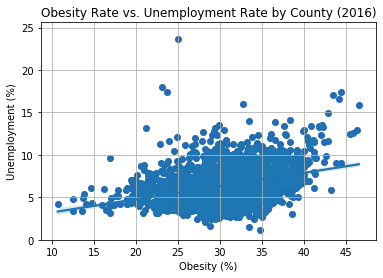

In [715]:
#Obesity vs Unemployment
#obtain the x and y coordinates for x and y coordinates

#get limits for x axis
x_limit_min = final_data["Obesity (%)"].min()
# x_limit_min
x_limit_max = final_data["Obesity (%)"].max()
# x_limit_max


#graphing for Obesity vs Unemployment
#max unemployment limits
unemp_limit_min = final_data["Unemployment (%)"].min()
# unemp_limit_min
unemp_limit_max = final_data["Unemployment (%)"].max()
# unemp_limit_max

#Obesity vs Unemployment
obesity_vs_unemp = plt.scatter(final_data["Obesity (%)"], final_data["Unemployment (%)"], marker="o", 
                               facecolors="blue", edgecolors="black", s=30, alpha=0.75)
plt.scatter

# Incorporate the other graph properties

# Set your x and y limits
plt.xlim(x_limit_min-2, x_limit_max+2)
plt.ylim(0, unemp_limit_max+2)

#label x and y axis

plt.xlabel("Obesity (%)")
plt.ylabel("Unemployment (%)")

#add header
plt.title(f"Obesity Rate vs. Unemployment Rate by County (2016)")

#add trendline
sns.regplot(final_data["Obesity (%)"],final_data["Unemployment (%)"])


# Set a grid on the plot
plt.grid()

# Save Figure
plt.savefig("Obesity_vs_Unemployment.png")

# Show plot
plt.show()


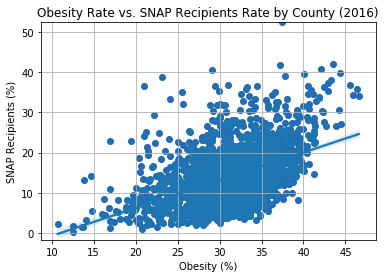

In [716]:
#Obesity vs SNAP Recipients
#obtain the x and y coordinates for x and y coordinates

#get limits for x axis
#x_limit_min = final_data["Obesity (%)"].min()
# x_limit_min
#x_limit_max = final_data["Obesity (%)"].max()
# x_limit_max


#graphing for Obesity vs SNAP Recipients
#max SNAP Recipients limits
snap_limit_min = final_data["SNAP Recipients (%)"].min()
# unemp_limit_min
snap_limit_max = final_data["SNAP Recipients (%)"].max()
# unemp_limit_max

#Obesity vs SNAP Recipients
obesity_vs_snap = plt.scatter(final_data["Obesity (%)"], final_data["SNAP Recipients (%)"], marker="o", 
                               facecolors="blue", edgecolors="black", s=30, alpha=0.75)
plt.scatter

# Incorporate the other graph properties

# Set your x and y limits
plt.xlim(x_limit_min-2, x_limit_max+2)
plt.ylim(snap_limit_min-2, snap_limit_max)

#label x and y axis

plt.xlabel("Obesity (%)")
plt.ylabel("SNAP Recipients (%)")

#add header
plt.title(f"Obesity Rate vs. SNAP Recipients Rate by County (2016)")

#add trendline
sns.regplot(final_data["Obesity (%)"],final_data["SNAP Recipients (%)"])


# Set a grid on the plot
plt.grid()

# Save Figure
plt.savefig("Obesity_vs_SNAP_Recipients.png")

# Show plot
plt.show()

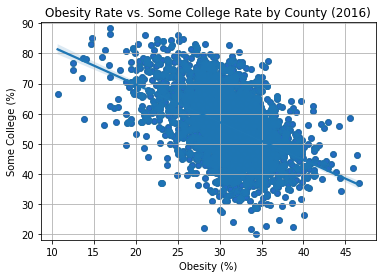

In [717]:
#Obesity vs Some College
#obtain the x and y coordinates for x and y coordinates

#get limits for x axis
#x_limit_min = final_data["Obesity (%)"].min()
# x_limit_min
#x_limit_max = final_data["Obesity (%)"].max()
# x_limit_max


#graphing for Obesity vs Some College
#max Some College limits
college_limit_min = final_data["Some College (%)"].min()
# college_limit_min
college_limit_max = final_data["Some College (%)"].max()
# college_limit_max

#Obesity vs Some College
obesity_vs_college = plt.scatter(final_data["Obesity (%)"], final_data["Some College (%)"], marker="o", 
                               facecolors="blue", edgecolors="black", s=30, alpha=0.75)
plt.scatter

# Incorporate the other graph properties

# Set your x and y limits
plt.xlim(x_limit_min-2, x_limit_max+2)
plt.ylim(college_limit_min-2, college_limit_max+2)

#label x and y axis

plt.xlabel("Obesity (%)")
plt.ylabel("Some College (%)")

#add header
plt.title(f"Obesity Rate vs. Some College Rate by County (2016)")

#add trendline
sns.regplot(final_data["Obesity (%)"],final_data["Some College (%)"])


# Set a grid on the plot
plt.grid()

# Save Figure
plt.savefig("Obesity_vs_Some_College.png")

# Show plot
plt.show()

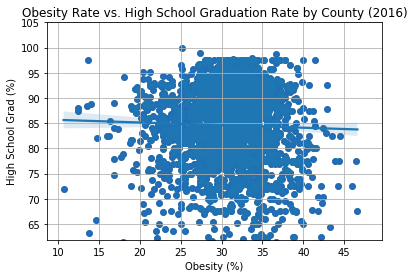

In [718]:
#Obesity vs High School Graduate
#obtain the x and y coordinates for x and y coordinates

#get limits for x axis
#x_limit_min = final_data["Obesity (%)"].min()
# x_limit_min
#x_limit_max = final_data["Obesity (%)"].max()
# x_limit_max


#graphing for Obesity vs High School Graduate
#max High School Graduate limits
hs_limit_min = final_data["High School Grad (%)"].min()
# highschool_limit_min
hs_limit_max = final_data["High School Grad (%)"].max()
# highschool_limit_max

#Obesity vs High School Graduate
obesity_vs_hs = plt.scatter(final_data["Obesity (%)"], final_data["High School Grad (%)"], marker="o", 
                               facecolors="blue", edgecolors="black", s=30, alpha=0.75)
plt.scatter

# Incorporate the other graph properties

# Set your x and y limits
plt.xlim(x_limit_min-2, x_limit_max+3)
plt.ylim(hs_limit_min+40, hs_limit_max+5)

#label x and y axis

plt.xlabel("Obesity (%)")
plt.ylabel("High School Grad (%)")

#add header
plt.title(f"Obesity Rate vs. High School Graduation Rate by County (2016)")

#add trendline
sns.regplot(final_data["Obesity (%)"],final_data["High School Grad (%)"])


# Set a grid on the plot
plt.grid()

# Save Figure
plt.savefig("Obesity_vs_hs_grad.png")

# Show plot
plt.show()

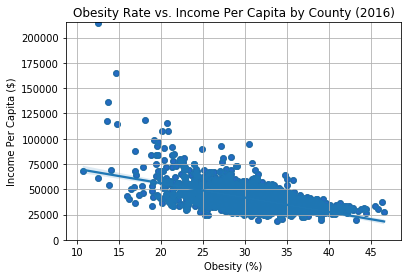

In [719]:
#Obesity vs Income Per Capita
#obtain the x and y coordinates for x and y coordinates

#get limits for x axis
#x_limit_min = final_data["Obesity (%)"].min()
# x_limit_min
#x_limit_max = final_data["Obesity (%)"].max()
# x_limit_max


#graphing for Obesity vs Income Per Capita
#max income limits
income_limit_min = final_data["Income Per Capita ($)"].min()
# income_limit_min
income_limit_max = final_data["Income Per Capita ($)"].max()
# income_limit_max

#Obesity vs Income Per Capita
obesity_vs_income = plt.scatter(final_data["Obesity (%)"], final_data["Income Per Capita ($)"], marker="o", 
                               facecolors="blue", edgecolors="black", s=30, alpha=0.75)
plt.scatter

# Incorporate the other graph properties

# Set your x and y limits
plt.xlim(x_limit_min-2, x_limit_max+2)
plt.ylim(0, income_limit_max+1000)

#label x and y axis

plt.xlabel("Obesity (%)")
plt.ylabel("Income Per Capita ($)")

#add header
plt.title(f"Obesity Rate vs. Income Per Capita by County (2016)")

#add trendline
sns.regplot(final_data["Obesity (%)"],final_data["Income Per Capita ($)"])


# Set a grid on the plot
plt.grid()

# Save Figure
plt.savefig("Obesity_vs_Income_Per_Capita.png")

# Show plot
plt.show()

In [720]:
#Inital Regression Analysis with Explicit Intercept
X = final_data[["Unemployment (%)", "SNAP Recipients (%)", "Income Per Capita ($)", "Some College (%)", "High School Grad (%)"]]
y = final_data["Obesity (%)"]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Obesity (%)   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                          2.775e+04
Date:                Tue, 19 May 2020   Prob (F-statistic):                        0.00
Time:                        23:44:31   Log-Likelihood:                         -7054.4
No. Observations:                2483   AIC:                                  1.412e+04
Df Residuals:                    2478   BIC:                                  1.415e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Unemployment (%)          0.3812      0.053      7.258      0.000       0.278       0.484
SNAP Recipients (%)       0.3762      0.018     21.083      0.000       0.341       0.411
Income Per Capita ($)    -0.0001   9.52e-06    -11.086      0.000      -0.000   -8.69e-05
Some College (%)          0.0647      0.009      7.288      0.000       0.047       0.082
High School Grad (%)      0.2814      0.006     47.506      0.000       0.270       0.293
==============================================================================
Omnibus:                       45.794   Durbin-Watson:                   1.404
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.478
Skew:                          -0.133   Prob(JB):                     5.52e-18
Kurtosis:                       3.835   Cond. No.                     2.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [721]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["X"] = X.columns
vif.round(1)

,VIF Factor,X
0,18.4,Unemployment (%)
1,10.8,SNAP Recipients (%)
2,23.0,Income Per Capita ($)
3,37.1,Some College (%)
4,36.6,High School Grad (%)


In [722]:
#Inital Regression Analysis with Explicit Intercept
X = final_data[["Unemployment (%)", "SNAP Recipients (%)", "Income Per Capita ($)", "Some College (%)", "High School Grad (%)"]]
y = final_data["Obesity (%)"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

C:\Users\areer\Anaconda3\envs\pandas\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Obesity (%)   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     321.6
Date:                Tue, 19 May 2020   Prob (F-statistic):          6.26e-266
Time:                        23:44:31   Log-Likelihood:                -6644.9
No. Observations:                2483   AIC:                         1.330e+04
Df Residuals:                    2477   BIC:                         1.334e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    33.8355      1.088     31.107      0.000      31.703      35.968
Unemployment (%)         -0.0311      0.046     -0.670      0.503      -0.122       0.060
SNAP Recipients (%)       0.1596      0.017      9.578      0.000       0.127       0.192
Income Per Capita ($)    -0.0001   8.18e-06    -17.890      0.000      -0.000      -0.000
Some College (%)         -0.0665      0.009     -7.706      0.000      -0.083      -0.050
High School Grad (%)      0.0563      0.009      6.396      0.000       0.039       0.074
==============================================================================
Omnibus:                       80.637   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.510
Skew:                          -0.364   Prob(JB):                     3.33e-23
Kurtosis:                       3.686   Cond. No.                     6.45e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [723]:
vif_Itc = pd.DataFrame()
vif_Itc["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_Itc["X"] = X.columns
vif_Itc.round(1)

,VIF Factor,X
0,237.1,const
1,1.9,Unemployment (%)
2,2.4,SNAP Recipients (%)
3,1.7,Income Per Capita ($)
4,1.9,Some College (%)
5,1.2,High School Grad (%)


In [724]:
#Revised Regression analysis to remove unemployment due to unstable relationship after running multiple samples and 
#to address multicollinearity issue
X = final_data[["SNAP Recipients (%)", "Income Per Capita ($)", "Some College (%)",]]
y = final_data["Obesity (%)"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Obesity (%)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     513.5
Date:                Tue, 19 May 2020   Prob (F-statistic):          1.64e-259
Time:                        23:44:31   Log-Likelihood:                -6666.1
No. Observations:                2483   AIC:                         1.334e+04
Df Residuals:                    2479   BIC:                         1.336e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    39.2607      0.581     67.586      0.000      38.122      40.400
SNAP Recipients (%)       0.1221      0.014      9.040      0.000       0.096       0.149
Income Per Capita ($)    -0.0001   8.25e-06    -17.769      0.000      -0.000      -0.000
Some College (%)         -0.0725      0.009     -8.455      0.000      -0.089      -0.056
==============================================================================
Omnibus:                      100.879   Durbin-Watson:                   1.208
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.899
Skew:                          -0.422   Prob(JB):                     3.76e-29
Kurtosis:                       3.743   Cond. No.                     3.42e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [725]:
vif_3v = pd.DataFrame()
vif_3v["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_3v["X"] = X.columns
vif_3v.round(1)

,VIF Factor,X
0,66.5,const
1,1.6,SNAP Recipients (%)
2,1.7,Income Per Capita ($)
3,1.8,Some College (%)


In [726]:
#Revised Regression analysis to comparing SNAP percentage and some college to address multicollinearity issue
X = final_data[["SNAP Recipients (%)", "Some College (%)"]]
y = final_data["Obesity (%)"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Obesity (%)   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     543.5
Date:                Tue, 19 May 2020   Prob (F-statistic):          1.90e-196
Time:                        23:44:31   Log-Likelihood:                -6814.9
No. Observations:                2483   AIC:                         1.364e+04
Df Residuals:                    2480   BIC:                         1.365e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  36.2492      0.590     61.457      0.000      35.093      37.406
SNAP Recipients (%)     0.1872      0.014     13.573      0.000       0.160       0.214
Some College (%)       -0.1404      0.008    -17.230      0.000      -0.156      -0.124
==============================================================================
Omnibus:                      141.200   Durbin-Watson:                   1.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.056
Skew:                          -0.540   Prob(JB):                     2.93e-40
Kurtosis:                       3.771   Cond. No.                         457.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [727]:
vif_Cl = pd.DataFrame()
vif_Cl["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_Cl["X"] = X.columns
vif_Cl.round(1)

,VIF Factor,X
0,60.9,const
1,1.5,SNAP Recipients (%)
2,1.5,Some College (%)


In [728]:
#Final Regression analysis to comparing SNAP percentage and some college to address multicollinearity issue
X = final_data[["SNAP Recipients (%)", "Income Per Capita ($)"]]
y = final_data["Obesity (%)"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Obesity (%)   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     714.2
Date:                Tue, 19 May 2020   Prob (F-statistic):          1.07e-245
Time:                        23:44:31   Log-Likelihood:                -6701.4
No. Observations:                2483   AIC:                         1.341e+04
Df Residuals:                    2480   BIC:                         1.343e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    35.8824      0.428     83.913      0.000      35.044      36.721
SNAP Recipients (%)       0.1635      0.013     12.815      0.000       0.138       0.189
Income Per Capita ($)    -0.0002   7.49e-06    -23.723      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      126.248   Durbin-Watson:                   1.241
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.755
Skew:                          -0.471   Prob(JB):                     1.13e-38
Kurtosis:                       3.895   Cond. No.                     2.48e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [729]:
vif_Inc = pd.DataFrame()
vif_Inc["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_Inc["X"] = X.columns
vif_Inc.round(1)

,VIF Factor,X
0,35.1,const
1,1.4,SNAP Recipients (%)
2,1.4,Income Per Capita ($)


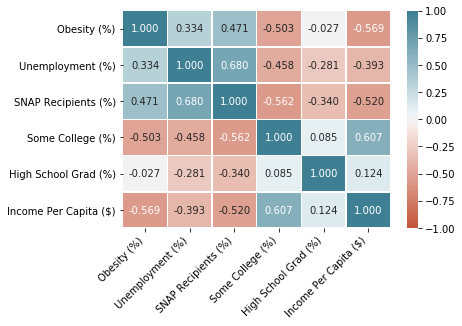

In [730]:
#Correlation Matrix plots
corr = final_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    linewidths=0.5,
    annot=True, 
    fmt=".3f"
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',    
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
;

# Save Figure
plt.savefig("Obesity_Correlation_Matrix.png", figsize=(20,24))

# Show plot
plt.show()

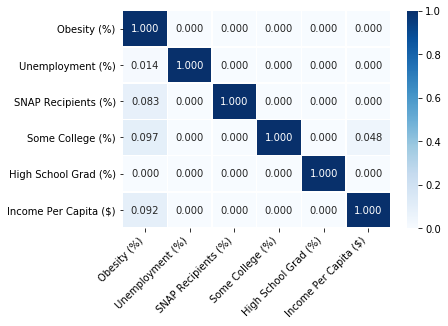

In [731]:
#pps matrix plot
health=final_data.loc[:, ["Obesity (%)", "Unemployment (%)", "SNAP Recipients (%)", 
                                  "Some College (%)", "High School Grad (%)", "Income Per Capita ($)"]]
ax = sns.heatmap(pps.matrix(health), vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, fmt=".3f")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
;

# Save Figure
plt.savefig("Obesity_PPS_Matrix.png", figsize=(20,24))

# Show plot
plt.show()

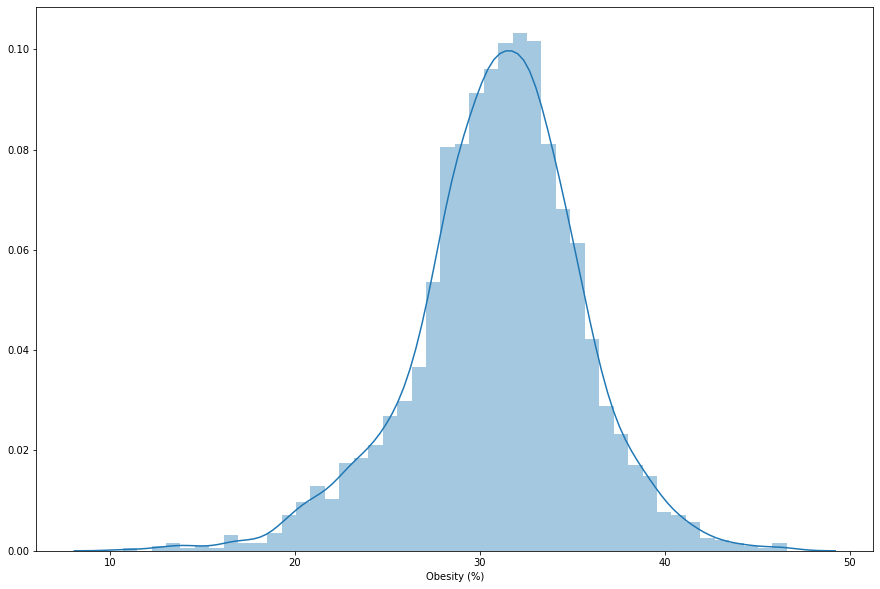

In [732]:
#Let's check the average value of the “Obesity (%)” column.
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(health['Obesity (%)'])

In [733]:
n_features = 5
X = health[['Unemployment (%)', 'SNAP Recipients (%)', 'Some College (%)', 'High School Grad (%)', 'Income Per Capita ($)']]
y = health['Obesity (%)'].values
X, y = make_regression(n_features=n_features, 
                       n_informative=n_features, random_state=0, 
                       noise=0.5, bias=100.0)
print(X.shape)

(100, 5)


C:\Users\areer\Anaconda3\envs\pandas\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\areer\Anaconda3\envs\pandas\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:794: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\areer\Anaconda3\envs\pandas\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:796: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


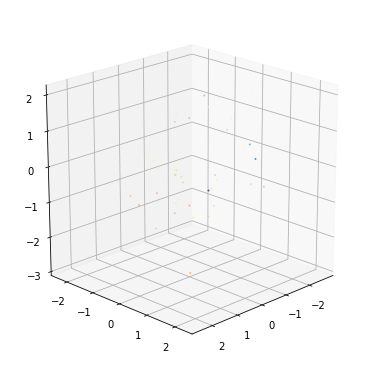

In [734]:
#fig = plt.figure(figsize=plt.figaspect(0.5))
fig = plt.figure(1, figsize=(5, 5))
axes = Axes3D(fig, elev=20, azim=45)
axes.scatter(X[:,0], X[:,1], X[:,2], X[:,3], X[:,4], c=y, cmap=plt.cm.get_cmap("Spectral"))
plt.show()

In [735]:
model1 = LinearRegression()

#Fitting our model with all of our features in X
model1.fit(X, y)

print(model1.intercept_.round(4))

print(model1.coef_.round(4))

score = model1.score(X, y)
print(f"R2 Score: {score.round(8)}")

99.9027
[45.6668 85.7497 98.0367 11.6971 42.3621]
R2 Score: 0.99998844


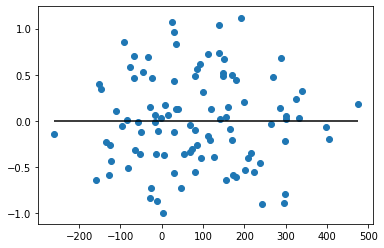

In [736]:
predictions = model1.predict(X)
# # Plot Residuals
plt.scatter(predictions, predictions - y)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [737]:
# Split the data into training and testing

### BEGIN SOLUTION
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=0)
### END SOLUTION

In [738]:
model2 = LinearRegression()  
model2.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [739]:
training_score = model2.score(X_train, y_train)
testing_score = model2.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9999904979713992
Testing Score: 0.9999777079226346


In [740]:
y_pred = model2.predict(X_test)

In [741]:
act_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
act_pred.head()

,Actual,Predicted
0,-15.870744,-15.745352
1,298.879595,298.698699
2,95.576011,95.132783
3,-24.915341,-24.543304
4,47.653343,46.758392


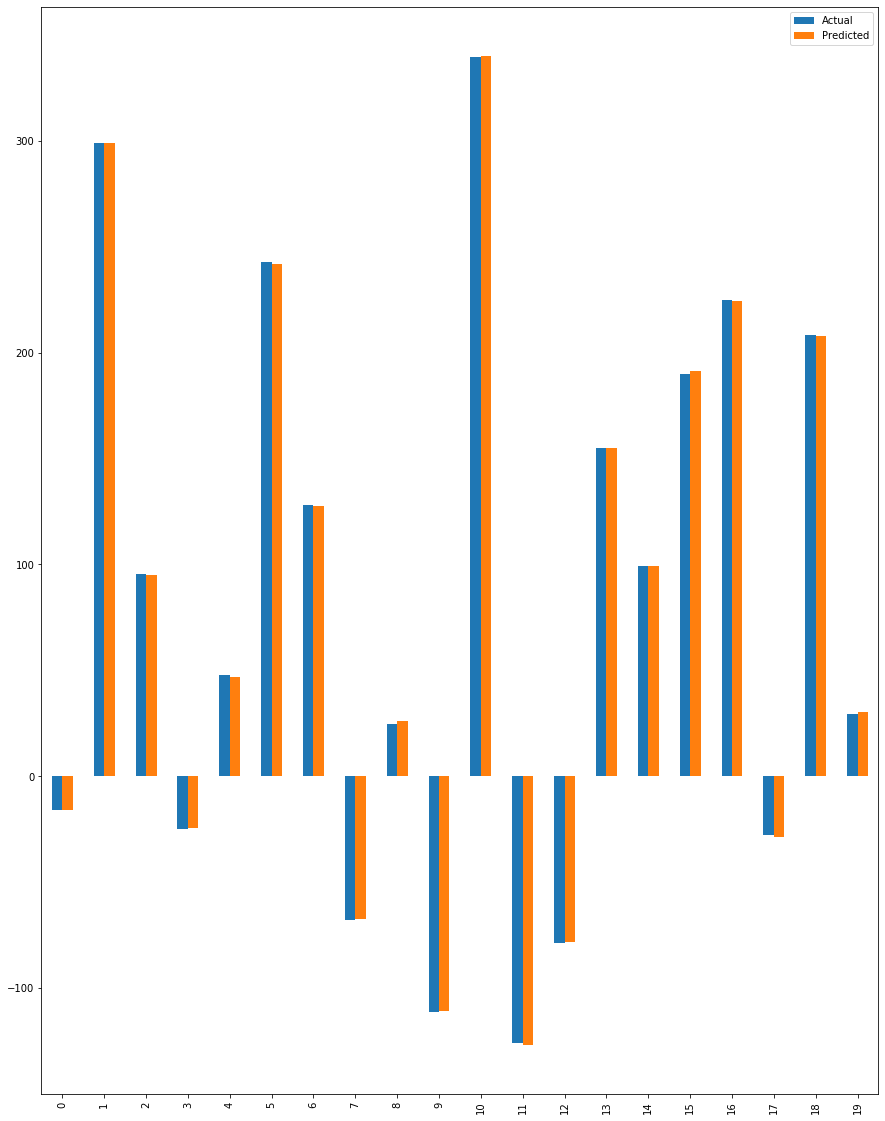

In [742]:
act_pred.plot(kind='bar',figsize=(15,20))
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [743]:
print('Mean Absolute Error:', 
      metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', 
      metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
score = model2.score(X_test, y_test)
print(f"R2 Score: {score}")

Mean Absolute Error: 0.5456332241355334
Mean Squared Error: 0.4061054951609524
Root Mean Squared Error: 0.637264070194572
R2 Score: 0.9999777079226346


In [744]:
# Assign X (features) and y (target)

### BEGIN SOLUTION
X2 = health[['SNAP Recipients (%)', 'Some College (%)']]
y = health['Obesity (%)'].values
print(X2.shape)
### END SOLUTION

(2483, 2)


In [745]:
# Split the data into training and testing

### BEGIN SOLUTION
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, train_size=0.8, test_size=0.2, random_state=0)
### END SOLUTION

In [746]:
model3 = LinearRegression()  
model3.fit(X_train2, y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [747]:
training_score2 = model3.score(X_train2, y_train2)
testing_score2 = model3.score(X_test2, y_test2)

print(f"Training Score: {training_score2}")
print(f"Testing Score: {testing_score2}")

Training Score: 0.31950122177347784
Testing Score: 0.2345894358402902


In [748]:
print(model3.intercept_)
print(model3.coef_)

36.14857173657545
[ 0.19958252 -0.1419945 ]


In [749]:
y_pred2 = model3.predict(X_test2)

In [750]:
act_pred2 = pd.DataFrame({'Actual': y_test2, 'Predicted': y_pred2})
act_pred2.head()

,Actual,Predicted
0,30.8,30.429300
1,39.2,35.011378
2,33.9,31.686971
3,37.8,32.962239
4,30.3,31.554480


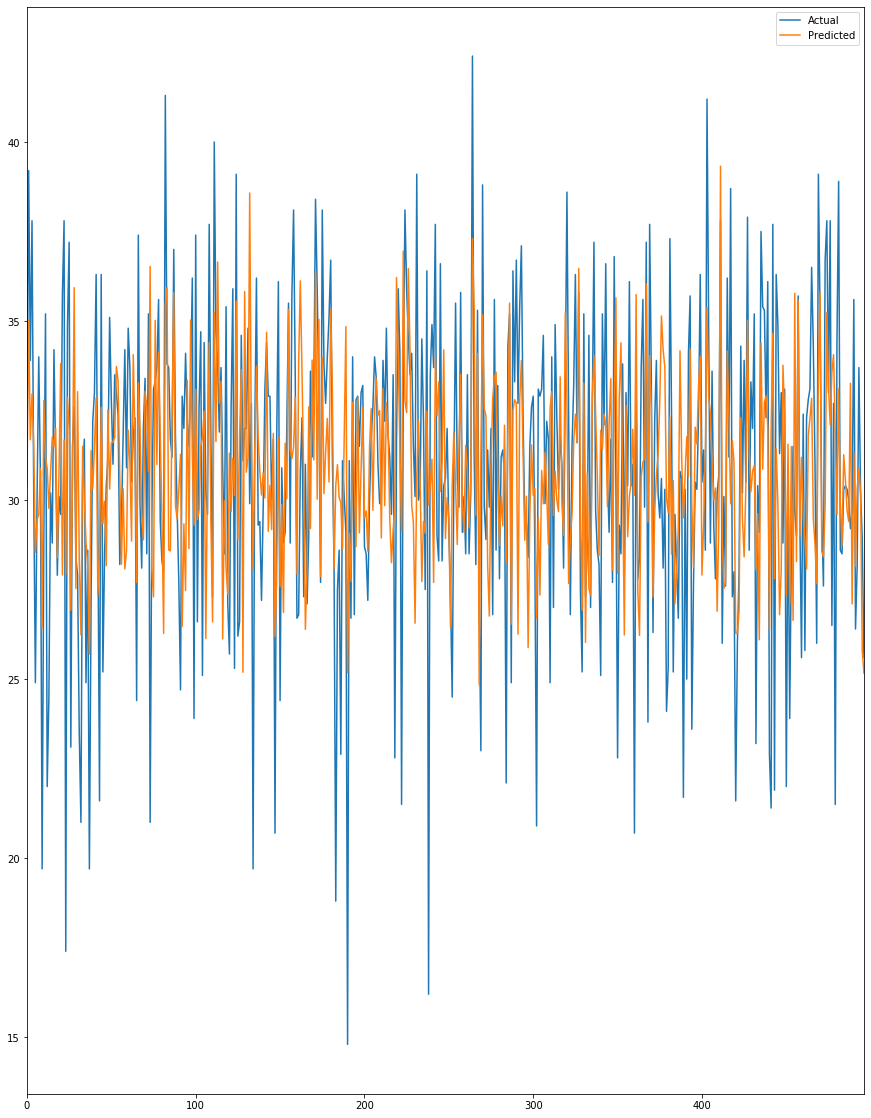

In [751]:
act_pred2.plot(kind='line',figsize=(15,20))
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [752]:
print('Mean Absolute Error:', 
      metrics.mean_absolute_error(y_test2, y_pred2))  
print('Mean Squared Error:', 
      metrics.mean_squared_error(y_test2, y_pred2))  
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)))
score = model3.score(X_test2, y_test2)
print(f"R2 Score: {score}")

Mean Absolute Error: 2.9905543198859728
Mean Squared Error: 13.987793108739124
Root Mean Squared Error: 3.7400258165872495
R2 Score: 0.2345894358402902


In [753]:
# Assign X (features) and y (target)

### BEGIN SOLUTION
X3 = health[["SNAP Recipients (%)", "Income Per Capita ($)"]]
y = health["Obesity (%)"].values
print(X3.shape)
### END SOLUTION

(2483, 2)


In [754]:
# Split the data into training and testing

### BEGIN SOLUTION
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, train_size=0.8, test_size=0.2, random_state=0)
### END SOLUTION

In [755]:
model4 = LinearRegression()  
model4.fit(X_train3, y_train3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [756]:
training_score3 = model4.score(X_train3, y_train3)
testing_score3 = model4.score(X_test3, y_test3)

print(f"Training Score: {training_score3}")
print(f"Testing Score: {testing_score3}")

Training Score: 0.3798368583865298
Testing Score: 0.2978074885241563


In [757]:
print(model4.intercept_.round(4))
print(model4.coef_.round(4))

35.6226
[ 0.1776 -0.0002]


In [758]:
y_pred3 = model4.predict(X_test3)

In [759]:
act_pred3 = pd.DataFrame({'Actual': y_test3, 'Predicted': y_pred3})
act_pred3.head()

,Actual,Predicted
0,30.8,31.127933
1,39.2,35.461964
2,33.9,31.903785
3,37.8,34.590734
4,30.3,32.335533


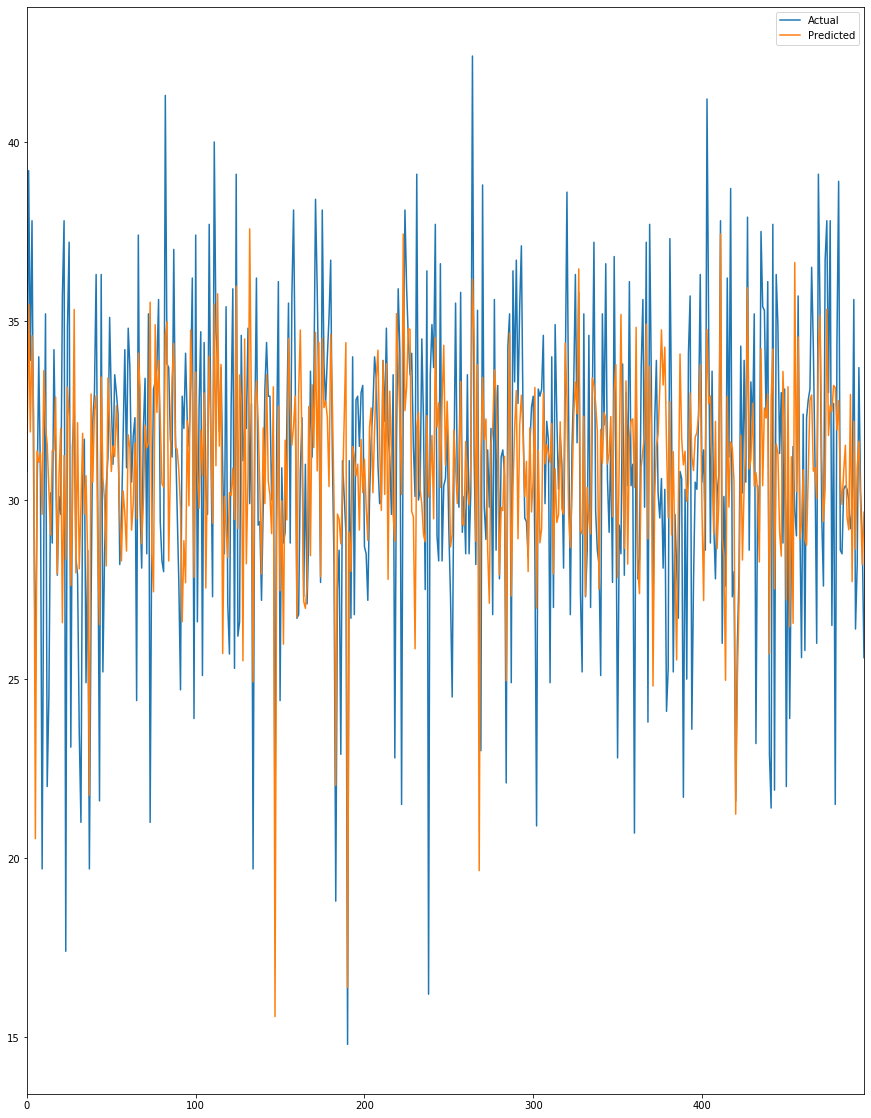

In [760]:
act_pred3.plot(kind='line',figsize=(15,20))
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [761]:
print('Mean Absolute Error:', 
      metrics.mean_absolute_error(y_test3, y_pred3))  
print('Mean Squared Error:', 
      metrics.mean_squared_error(y_test3, y_pred3))  
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test3, y_pred3)))
score = model4.score(X_test3, y_test3)
print(f"R2 Score: {score}")

Mean Absolute Error: 2.857589521196481
Mean Squared Error: 12.832490212377772
Root Mean Squared Error: 3.5822465314907865
R2 Score: 0.2978074885241563


In [762]:
# Assign X (features) and y (target)

### BEGIN SOLUTION
X = health[['Unemployment (%)', 'SNAP Recipients (%)', 'Some College (%)', 'High School Grad (%)', 'Income Per Capita ($)']]
y = health['Obesity (%)'].values.reshape(-1, 1)
print(X.shape, y.shape)
### END SOLUTION

(2483, 5) (2483, 1)


In [763]:
# Split the data into training and testing

### BEGIN SOLUTION
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
### END SOLUTION

In [764]:
# Create a StandardScater model and fit it to the training data

### BEGIN SOLUTION
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
### END SOLUTION

In [765]:
# Transform the training and testing data using the X_scaler and y_scaler models

### BEGIN SOLUTION
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
### END SOLUTION

In [766]:
# Create a LinearRegression model and fit it to the scaled training data

### BEGIN SOLUTION
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
### END SOLUTION

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

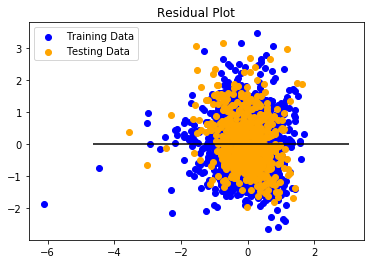

In [767]:
# Make predictions using the X_test_scaled data
# Plot y_test_scaled vs y_test_scaled
# Scatter plot y_test_scaled vs predictions

### BEGIN SOLUTION
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [768]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

### BEGIN SOLUTION

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.6729074135253772, R2: 0.4341976406850878


In [769]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.6773490058975704, R2: 0.43046300588572356


In [770]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity


### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.6756281955897733, R2: 0.43190991895654873
